In [1]:
%%capture
%pip install qldpc
%pip install matplotlib

# Computing logical error rates

Here we show how to compute the logical error rates of error-correcting codes.  We consider both a code capacity model, in which a code accumulates errors that are corrected noiselessly, and a simulation of logical error rates in a quantum memory experiment with circuit-level noise.

In [2]:
import os
from collections.abc import Sequence

import matplotlib.pyplot as plt
import numpy as np
import sinter

from qldpc import circuits, codes
from qldpc.objects import Pauli, PauliXZ

%matplotlib inline

## Code capacity

In the simplest code capacity model, physical errors are sampled by flipping each bit (or depolarizing each qubit) of the code with some i.i.d. probability.  The logical error rate of the code is then the probability that a physical error is decoded incorrectly, resulting in a logical error upon correction.  For a fixed noise model, this logical error rate is a joint property of (a) the code and (b) the decoder.

Our main driver for computing logical error rates in a code capacity model is the `.get_logical_error_rate_func` method of any `ClassicalCode` or `CSSCode`.  This method builds a function that maps physical error rates to logical error rates.  Below, we provide a function that uses `.get_logical_error_rate_func` to produce a plot of physical vs. logical error rates.

In [3]:
def make_code_capacity_figure(
    codes_to_plot: Sequence[codes.ClassicalCode | codes.CSSCode],
    error_rates: Sequence[float] = list(np.logspace(-2, -0.1, 100)),
    num_samples: int = 10**4,
    distance_trials: int = 100,
    figsize: tuple[int, int] = (5, 4),
    **decoding_kwargs: object,
) -> tuple[plt.Figure, plt.Axes]:
    """Plot physical vs. logical error rates for the given codes in a code capacity model.

    Args:
        codes_to_plot: The codes whose error rates we want to plot.
        error_rates: The i.i.d. probabilities of physical errors on each bit/qubit.
        num_samples: The number of times we sample physical errors.
        distance_trials: If the code distance is not known, estimate it with this many trials.
        figsize: The size of the figure to produce.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        The matplotlib.pyplot figure and axis.
    """
    figure, axis = plt.subplots(figsize=figsize)

    for code in codes_to_plot:
        get_logical_error_rate = code.get_logical_error_rate_func(
            num_samples, max(error_rates), **decoding_kwargs
        )
        logical_rates, stderrs = get_logical_error_rate(error_rates)
        label = get_label(code, distance_trials)
        line, *_ = axis.plot(error_rates, logical_rates, label=label)
        axis.fill_between(
            error_rates,
            logical_rates - stderrs,
            logical_rates + stderrs,
            color=line.get_color(),
            alpha=0.2,
        )

    axis.axline(
        (0, 0),
        slope=1,
        color="k",
        linestyle=":",
        label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$",
    )
    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_xlim(right=1)
    axis.set_ylim(bottom=max(min(error_rates) ** 2, axis.get_ylim()[0]), top=1)
    axis.set_xlabel(r"physical error rate")
    axis.set_ylabel(r"logical error rate")
    axis.legend(loc="best")
    axis.grid(which="both")
    figure.tight_layout()

    return figure, axis


def get_label(
    code: codes.ClassicalCode | codes.QuditCode,
    distance_trials: bool | int = False,
) -> str:
    """Get a label for a code in a figure."""
    known_distance = code.get_distance_if_known()
    if isinstance(known_distance, int):
        return f"$d={known_distance}$"
    if not distance_trials:
        return f"[{len(code)}, {code.dimension}]"
    distance_estimate = code.get_distance_bound(num_trials=int(distance_trials))
    return f"[{len(code)}, {code.dimension}, <= {distance_estimate}]"

### The repetition and surface codes

For these codes, we decode with minimum-weight perfect matching (MWPM).

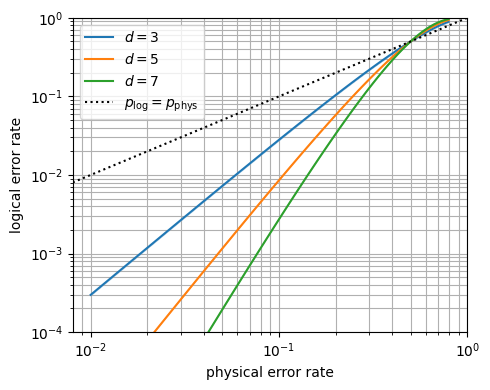

In [4]:
rep_codes = [codes.RepetitionCode(dist) for dist in [3, 5, 7]]
make_code_capacity_figure(rep_codes, with_MWPM=True)
plt.show()

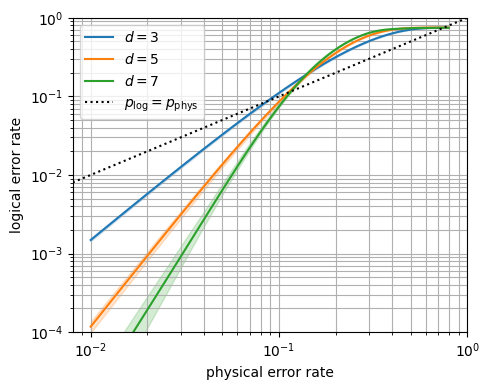

In [5]:
surface_codes = [codes.SurfaceCode(dist) for dist in [3, 5, 7]]
make_code_capacity_figure(surface_codes, with_MWPM=True)
plt.show()

### Bivariate bicycle codes

As introduced in [arXiv:2308.07915](https://arxiv.org/abs/2308.07915), these codes can be decoded with BD-OSD.

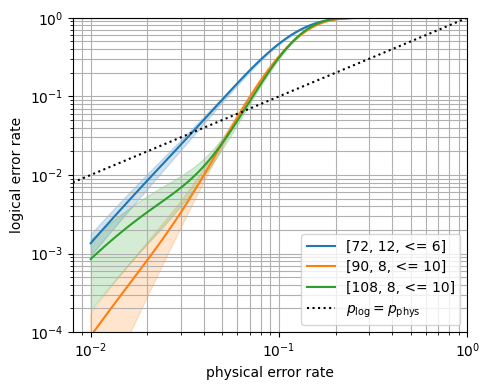

In [6]:
from sympy.abc import x, y

bb_codes = [
    codes.BBCode(
        {x: 6, y: 6},
        x**3 + y + y**2,
        y**3 + x + x**2,
    ),
    codes.BBCode(
        {x: 15, y: 3},
        x**9 + y + y**2,
        1 + x**2 + x**7,
    ),
    codes.BBCode(
        {x: 9, y: 6},
        x**3 + y + y**2,
        y**3 + x + x**2,
    ),
]
make_code_capacity_figure(bb_codes, with_BP_LSD=True)
plt.show()

## Quantum memory with circuit-level noise

We now consider using a code as a quantum memory, and consider running a (noisy) circuit for one error correction cycle.  The logical error rate is now the probability which an error correction cycle induces a logical error.  For a fixed noise model, this logical error rate is a joint property of (a) the code, (b) the decoder, and (c) the syndrome measurement strategy used for error correction.

More specifically, we consider small-scale memory experiments for the toric and surface codes:

- Build codes with varying code distance `d`.
- Compile circuits for syndrome measurement.
- Inject i.i.d. depolarizing noise with strength `p` after every gate in the circuit.
- Decode using BP+LSD + `sinter`.
- Sweep over `(d, p)` and estimate logical error rates for both Z- and X-type logical operators.

What is a “memory experiment”?  Prepare a logical state (e.g., `|0⟩_L` or `|+⟩_L`), perform `d` rounds of stabilizer measurements, then check if a logical operator has flipped at the end.  The resulting logical error rate as a function of the physical error rate lets you determine threshold behavior of a code.

The core feature in this demonstration is the `qldpc.circuits.get_memory_experiment` method, which constructs a noisy memory experiment circuit.  Below, we provide a function that collects these circuits into tasks that are handed over to `sinter` for simulating and estimating the error rates of Z-type and X-type logical observables.

In [7]:
def run_memory_experiments(
    codes_to_simulate: Sequence[codes.ClassicalCode | codes.CSSCode],
    basis: PauliXZ,
    error_rates: Sequence[float] = list(np.logspace(-3, -2, 5)),
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    **decoding_kwargs: object,
) -> list[sinter.TaskStats]:
    """Use sinter to simulate memory cycles of the given codes.

    This function ...
      1. Builds a memory experiment for each code.
      2. Adds a depolarizing noise to all gates, at the provided error rates.
      2. Wraps each configuration as a `sinter.Task``.
      3. Runs batched Monte Carlo sampling with `sinter.collect`.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        basis: The type of logical operator whose errors are tracked.
        error_rates: The i.i.d. probabilities of physical errors on each bit/qubit.
        max_shots: Stop sampling the circuit after this many shots.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        A `sinter` stats object aggregating shots, errors, and metadata for downstream plotting.
    """
    tasks: list[sinter.Task] = []
    noise_models = {
        prob: circuits.DepolarizingNoiseModel(prob, include_idling_error=False)
        for prob in error_rates
    }
    for code in codes_to_simulate:
        distance = code.get_distance(bound=distance_trials)
        circuit = circuits.get_memory_experiment(code, basis=basis, num_rounds=distance)
        for prob in error_rates:
            noisy_circuit = noise_models[prob].noisy_circuit(circuit)
            tasks.append(
                sinter.Task(circuit=noisy_circuit, json_metadata={"dist": distance, "prob": prob})
            )

    decoder = circuits.SinterDecoder(**decoding_kwargs)
    return sinter.collect(
        num_workers=os.cpu_count() - 2,
        max_shots=max_shots,
        max_errors=100,
        tasks=tasks,
        decoders=["custom"],
        custom_decoders={"custom": decoder},
    )


def make_memory_experiment_plots(
    codes_to_simulate: Sequence[codes.ClassicalCode | codes.CSSCode],
    error_rates: Sequence[float] = list(np.logspace(-3, -2, 5)),
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    figsize: tuple[int, int] = (8, 4),
    **decoding_kwargs: object,
) -> tuple[plt.Figure, plt.Axes]:
    """Use sinter to simulate memory cycles of the given codes, and plot the results.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        error_rates: The i.i.d. probabilities of physical errors on each bit/qubit.
        max_shots: Stop sampling the circuit after this many shots.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        figsize: The size of the figure to produce.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        The matplotlib.pyplot figure and axis.
    """
    stats_z = run_memory_experiments(
        codes_to_simulate, Pauli.Z, error_rates, max_shots, max_errors, **decoding_kwargs
    )
    stats_x = run_memory_experiments(
        codes_to_simulate, Pauli.X, error_rates, max_shots, max_errors, **decoding_kwargs
    )

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=figsize)
    for axis, stats, basis in zip(axes, [stats_z, stats_x], ["Z", "X"]):
        sinter.plot_error_rate(
            ax=axis,
            stats=stats,
            x_func=lambda stats: stats.json_metadata["prob"],
            group_func=lambda stats: stats.json_metadata["dist"],
        )
        axis.axline(
            (0, 0),
            slope=1,
            color="k",
            linestyle=":",
            label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$",
        )
        axis.set_title(f"{basis} logicals")
        axis.set_xlabel("physical error rate")

    for axis in axes:
        axis.loglog()
        axis.grid(which="both")
    axes[1].legend()
    axes[0].set_ylabel("logical error rate")
    return fig, axes

### The toric code

Note that these simulations may take a while...

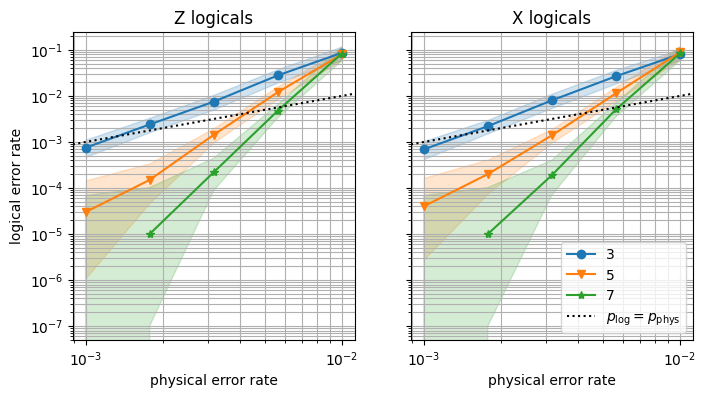

In [8]:
codes_to_simulate = [codes.ToricCode(dist, rotated=False) for dist in (3, 5, 7)]
decoding_kwargs = dict(
    with_BP_LSD=True, max_iter=30, bp_method="ms", lsd_method="lsd_cs", lsd_order=0
)
make_memory_experiment_plots(codes_to_simulate, **decoding_kwargs)
plt.show()

### The surface code

The surface code is decodable with minimum weight perfect matching (MWPM).

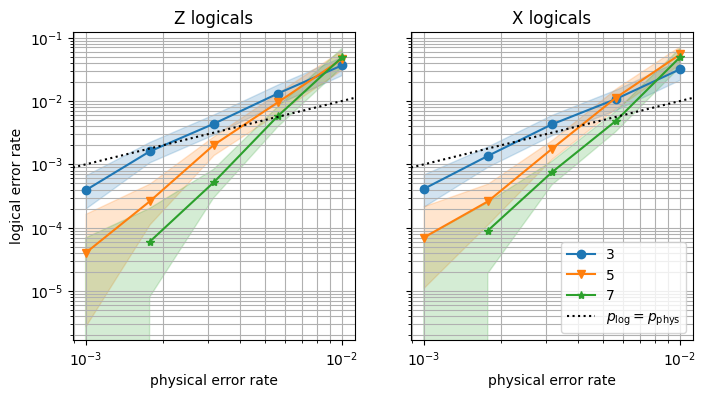

In [9]:
codes_to_simulate = [codes.SurfaceCode(dist, rotated=True) for dist in (3, 5, 7)]
make_memory_experiment_plots(codes_to_simulate, with_MWPM=True)
plt.show()